In [140]:
#import libraries
import numpy 
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [141]:
df = pd.read_csv(r'C:\Users\USER\Desktop\Data Science Academy\12_MacedonianStockExchangeMarket\dataset\data_mse_mse_historic_data_active.csv', sep="\t")

In [142]:
print(df.head())
print(df.shape)
print(df.columns)

         Date stock_id     Open     High      Low    Close   Volume  \
0  2020-08-25      ALK  12290.0  12222.0  12200.0  12200.0  3660440   
1  2020-08-24      ALK  12290.0  12290.0  12289.0  12290.0    73738   
2  2020-08-21      ALK  12223.0  12290.0  12289.0  12290.0   614476   
3  2020-08-20      ALK  12300.0  12300.0  12223.0  12223.0   651640   
4  2020-08-19      ALK  12300.0  12300.0  12300.0  12300.0  2952000   

   Adj Close  Quantity   Average  Change %  Volume Total  Ratio  Ratio 1m  \
0    12200.0       300  12201.47     -0.72       3660440  0.878     0.971   
1    12290.0         6  12289.67      0.00         73738  0.885     0.978   
2    12290.0        50  12289.52     -0.05        614476  0.885     0.978   
3    12223.0        53  12295.09     -0.04        651640  0.885     0.979   
4    12300.0       240  12300.00      0.00       2952000  0.885     0.979   

   Ratio 3m  Ratio 6m  Ratio 1y  Ratio 2y  Ratio 3y  
0     0.971     0.937     0.916     0.916     0.916  
1 

In [143]:
def features_build(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekOfYear'] = df.Date.dt.weekofyear

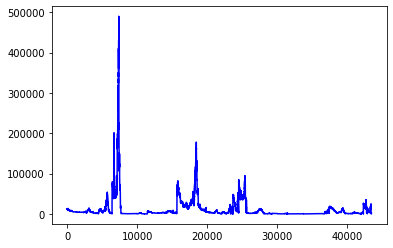

In [144]:
# Visualize the dataset
data = pd.read_csv(r'C:\Users\USER\Desktop\Data Science Academy\12_MacedonianStockExchangeMarket\dataset\data_mse_mse_historic_data_active.csv', sep="\t", usecols=['High'], parse_dates=True, squeeze=True)
plt.plot(data, color='blue')
plt.show()

#### TO DO

- missing data (dates)
- fill the missing data (about dates)
- fill the missing data from previous day
- target - close price, ratio


In [145]:
df['Date'] = pd.to_datetime(df['Date'])

In [146]:
users = df['stock_id'].unique()

In [147]:
dates = df.set_index('Date').index

In [148]:
print(users)

['ALK' 'BESK' 'FERS' 'GRNT' 'KMB' 'MPT' 'MTUR' 'OKTA' 'PKB' 'PPIV' 'REPL'
 'SBT' 'STBP' 'STB' 'STIL' 'TEL' 'TKVS' 'TNB' 'TTK' 'UNI' 'USJE' 'VITA']


In [149]:
print(dates)

DatetimeIndex(['2020-08-25', '2020-08-24', '2020-08-21', '2020-08-20',
               '2020-08-19', '2020-08-18', '2020-08-17', '2020-08-14',
               '2020-08-12', '2020-08-11',
               ...
               '2000-09-21', '2000-09-07', '2000-08-31', '2000-08-01',
               '2000-07-06', '2000-03-16', '2000-03-14', '2000-02-03',
               '1999-07-06', '1998-10-13'],
              dtype='datetime64[ns]', name='Date', length=43441, freq=None)


In [150]:
df.head()

,Date,stock_id,Open,High,Low,Close,Volume,Adj Close,Quantity,Average,Change %,Volume Total,Ratio,Ratio 1m,Ratio 3m,Ratio 6m,Ratio 1y,Ratio 2y,Ratio 3y
0,2020-08-25,ALK,12290.0,12222.0,12200.0,12200.0,3660440,12200.0,300,12201.47,-0.72,3660440,0.878,0.971,0.971,0.937,0.916,0.916,0.916
1,2020-08-24,ALK,12290.0,12290.0,12289.0,12290.0,73738,12290.0,6,12289.67,0.00,73738,0.885,0.978,0.978,0.944,0.922,0.922,0.922
2,2020-08-21,ALK,12223.0,12290.0,12289.0,12290.0,614476,12290.0,50,12289.52,-0.05,614476,0.885,0.978,0.978,0.944,0.922,0.922,0.922
3,2020-08-20,ALK,12300.0,12300.0,12223.0,12223.0,651640,12223.0,53,12295.09,-0.04,651640,0.885,0.979,0.979,0.945,0.923,0.923,0.923
4,2020-08-19,ALK,12300.0,12300.0,12300.0,12300.0,2952000,12300.0,240,12300.00,0.00,2952000,0.885,0.979,0.979,0.945,0.923,0.923,0.923


In [151]:
idx = pd.MultiIndex.from_product((dates, users), names=['Date', 'stock_id'])

In [152]:
df.set_index(['Date', 'stock_id']).reindex(idx, fill_value=0).reset_index()

,Date,stock_id,Open,High,Low,Close,Volume,Adj Close,Quantity,Average,Change %,Volume Total,Ratio,Ratio 1m,Ratio 3m,Ratio 6m,Ratio 1y,Ratio 2y,Ratio 3y
0,2020-08-25,ALK,12290.0,12222.0,12200.0,12200.0,3660440,12200.0,300,12201.47,-0.72,3660440,0.878,0.971,0.971,0.937,0.916,0.916,0.916
1,2020-08-25,BESK,0.0,0.0,0.0,0.0,0,0.0,0,0.00,0.00,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,2020-08-25,FERS,0.0,0.0,0.0,0.0,0,0.0,0,0.00,0.00,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,2020-08-25,GRNT,0.0,0.0,0.0,0.0,0,0.0,0,0.00,0.00,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,2020-08-25,KMB,6250.0,6300.0,6250.0,6300.0,771074,6300.0,123,6268.89,0.46,771074,0.702,1.002,1.002,0.802,0.802,0.802,0.802
5,2020-08-25,MPT,62000.0,62000.0,61800.0,62000.0,2848115,62000.0,46,61915.54,-0.14,2848115,0.356,0.947,0.914,0.812,0.775,0.775,0.775
6,2020-08-25,MTUR,4200.0,4100.0,4100.0,4100.0,123000,4100.0,30,4100.00,-2.38,123000,0.411,0.962,0.924,0.775,0.715,0.715,0.715
7,2020-08-25,OKTA,0.0,0.0,0.0,0.0,0,0.0,0,0.00,0.00,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000
8,2020-08-25,PKB,0.0,0.0,0.0,0.0,0,0.0,0,0.00,0.00,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000
9,2020-08-25,PPIV,0.0,0.0,0.0,0.0,0,0.0,0,0.00,0.00,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [153]:
df = df.set_index(['Date', 'stock_id']).reindex(idx, fill_value=0).reset_index().sort_values(by='stock_id')

In [154]:
print (df.Date.min())

1997-01-09 00:00:00


In [155]:
df1 = df.join(df.groupby('stock_id')['Date'].agg(['min', 'max']), on='stock_id')

In [156]:
df1.head()

,Date,stock_id,Open,High,Low,Close,Volume,Adj Close,Quantity,Average,...,Volume Total,Ratio,Ratio 1m,Ratio 3m,Ratio 6m,Ratio 1y,Ratio 2y,Ratio 3y,min,max
0,2020-08-25,ALK,12290.0,12222.0,12200.0,12200.0,3660440,12200.0,300,12201.47,...,3660440,0.878,0.971,0.971,0.937,0.916,0.916,0.916,1997-01-09,2020-08-25
760584,2016-12-29,ALK,0.0,0.0,0.0,0.0,0,0.0,0,0.00,...,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1997-01-09,2020-08-25
178838,2018-08-23,ALK,7951.0,7998.0,7901.0,7998.0,111875,7998.0,14,7991.07,...,111875,0.575,0.636,0.636,0.614,0.600,0.600,0.600,1997-01-09,2020-08-25
760606,2016-12-28,ALK,5350.0,5389.0,5350.0,5350.0,565650,5350.0,105,5387.14,...,565650,0.388,0.429,0.429,0.414,0.404,0.404,0.404,1997-01-09,2020-08-25
760628,2016-12-27,ALK,5330.0,5350.0,5350.0,5350.0,615250,5350.0,115,5350.00,...,615250,0.385,0.426,0.426,0.411,0.401,0.401,0.401,1997-01-09,2020-08-25


In [160]:
df1.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 955702 entries, 0 to 955701
Data columns (total 21 columns):
Date            955702 non-null datetime64[ns]
stock_id        955702 non-null object
Open            955702 non-null float64
High            955702 non-null float64
Low             955702 non-null float64
Close           955702 non-null float64
Volume          955702 non-null int64
Adj Close       955702 non-null float64
Quantity        955702 non-null int64
Average         955702 non-null float64
Change %        955619 non-null float64
Volume Total    955702 non-null int64
Ratio           955702 non-null float64
Ratio 1m        955702 non-null float64
Ratio 3m        955702 non-null float64
Ratio 6m        955702 non-null float64
Ratio 1y        955702 non-null float64
Ratio 2y        955702 non-null float64
Ratio 3y        955702 non-null float64
min             955702 non-null datetime64[ns]
max             955702 non-null datetime64[ns]
dtypes: datetime64[ns](3), float64(

In [166]:
df2 = df1[(df1['Date'].dt.year - df1['min'].dt.year) > 0]

In [168]:
df2

,Date,stock_id,Open,High,Low,Close,Volume,Adj Close,Quantity,Average,...,Volume Total,Ratio,Ratio 1m,Ratio 3m,Ratio 6m,Ratio 1y,Ratio 2y,Ratio 3y,min,max
0,2020-08-25,ALK,12290.0,12222.0,12200.0,12200.0,3660440,12200.0,300,12201.47,...,3660440,0.878,0.971,0.971,0.937,0.916,0.916,0.916,1997-01-09,2020-08-25
760584,2016-12-29,ALK,0.0,0.0,0.0,0.0,0,0.0,0,0.00,...,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1997-01-09,2020-08-25
178838,2018-08-23,ALK,7951.0,7998.0,7901.0,7998.0,111875,7998.0,14,7991.07,...,111875,0.575,0.636,0.636,0.614,0.600,0.600,0.600,1997-01-09,2020-08-25
760606,2016-12-28,ALK,5350.0,5389.0,5350.0,5350.0,565650,5350.0,105,5387.14,...,565650,0.388,0.429,0.429,0.414,0.404,0.404,0.404,1997-01-09,2020-08-25
760628,2016-12-27,ALK,5330.0,5350.0,5350.0,5350.0,615250,5350.0,115,5350.00,...,615250,0.385,0.426,0.426,0.411,0.401,0.401,0.401,1997-01-09,2020-08-25
178816,2018-08-24,ALK,7998.0,7905.0,7900.0,7901.0,6265562,7901.0,793,7901.09,...,6265562,0.569,0.629,0.629,0.607,0.593,0.593,0.593,1997-01-09,2020-08-25
760650,2016-12-26,ALK,5300.0,5330.0,5300.0,5330.0,185650,5330.0,35,5304.29,...,185650,0.382,0.422,0.422,0.408,0.398,0.398,0.398,1997-01-09,2020-08-25
178794,2018-08-27,ALK,7901.0,7950.0,7901.0,7950.0,665840,7950.0,84,7926.67,...,665840,0.571,0.631,0.631,0.609,0.595,0.595,0.595,1997-01-09,2020-08-25
760672,2016-12-23,ALK,5300.0,5340.0,5300.0,5300.0,995930,5300.0,187,5325.83,...,995930,0.383,0.424,0.424,0.409,0.400,0.400,0.400,1997-01-09,2020-08-25
178772,2018-08-29,ALK,7950.0,7920.0,7900.0,7900.0,1098860,7900.0,139,7905.47,...,1098860,0.569,0.629,0.629,0.607,0.593,0.593,0.593,1997-01-09,2020-08-25
